In [1]:
import time
import copy
import numpy as np
from skimage.filters import gaussian
import cv2 
import matplotlib.pyplot as plt
import pylab as pl
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)
from tifffile import imread, imsave
import pickle
import bobsegutils as bsu
from skimage.draw import circle
from scipy.spatial.distance import euclidean
import csv
from skimage import io
import math
from itertools import chain

Populating the interactive namespace from numpy and matplotlib


/Users/prakash/anaconda/envs/Py35forBobSeg/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
def subVector(vec1, vec2):
    """Makes a vector given two points using B-A given the coordinates of two points A and B
       Parameters: Two lists of vectors
       Returns a list
    """
    return [(vec2[0] - vec1[0], vec2[1] - vec1[1]) for vec1, vec2 in zip(vec1, vec2)] 

In [3]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  
    """
    return vector / np.linalg.norm(vector)
def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

### Reads noisy image, denoised image and the corresponding csv file for tracklets to serve as GT

In [4]:
base_path = "/Users/prakash/Downloads/Junction_Coupling_Analysis/max_2018001_lp823_control-03-05/"
noisy_image_filename = base_path+'MAX_2018001_LP823_Control-03-05_Myo_denoised.tif'
denoised_image_file_name = base_path+'MAX_2018001_LP823_Control-03-05_Myo_denoised.tif'
csv_path = base_path+'MAX_2018001_LP823_Control-03-05_tracklets.csv'
flow = imread(base_path + "MAX_2018001_LP823_Control-03-05_Flow.tif")
# noisy_flow = imread("/Users/prakash/Downloads/MAX_2018001_LP823_Control-02-02-2/")")
# noisy_flow = imread("/Users/prakash/Downloads/MAX_2018001_LP823_Control-02-02-2/")
noisy_image = imread(noisy_image_filename)
denoised_image = imread(denoised_image_file_name)
print('Shape of stack:', noisy_image.shape, denoised_image.shape)

Shape of stack: (61, 871, 587, 1) (61, 871, 587, 1)


### Extract flow vectors from tracklets in csv file

In [5]:
### Read the results csv file, delete all entries which are not coordinates and write it as a new csv file
puncta = []
edges = []
with open(csv_path,"r") as source:
    rdr= csv.reader( source )
    next(rdr)
    for line in source:
        if(line.startswith("edgep1,edgep2") ):
            break
        else:
            puncta.append(line[:-1])

edgeCount = False            
with open(csv_path,"r") as source:
    rdr= csv.reader( source )
    next(rdr)
    for line in source:
        if(line.startswith("edgep1,edgep2") ):
            edgeCount = True
        if(edgeCount):
            edges.append(line[:-1])
        

In [6]:
modified_edges = []
modified_puncta = []
for edge in range(1, len(edges)):
    modified_edges.append([float(edge) for edge in edges[edge].split(',')])
for punctum in range(len(puncta)):
    modified_puncta.append([float(punctum) for punctum in puncta[punctum].split(',')])

In [7]:
flow_vectors_gt = []
for edge in modified_edges:
    id1 = edge[0]
    id2 = edge[1]
    puncta1 = modified_puncta[int(id1)]
    puncta2 = modified_puncta[int(id2)]
    time_diff = np.abs(puncta1[-1] - puncta2[-1])
    if(puncta1[-1]<puncta2[-1] and time_diff ==1):
        time = int(puncta1[-1])
        x = puncta1[1]
        y = puncta1[2]
        u = puncta2[1] - puncta1[1]
        v = puncta2[2] - puncta1[2]
        
    elif(puncta2[-1]<puncta1[-1] and time_diff ==1):
        time = int(puncta2[-1])
        x = puncta2[1]
        y = puncta2[2]
        u = puncta1[1] - puncta2[1]
        v = puncta1[2] - puncta2[2]
    elif(puncta2[-1]==puncta1[-1]):
        continue
    flow_vectors_gt.append((x,y,u,v,time))

In [8]:
if len(set(flow_vectors_gt)) == len(flow_vectors_gt):
    print("no duplicates found!")

no duplicates found!


# Comparison of automated GUI flow beofre denoising vs after denoising

### Load flow images obtained from GUI for both denoised and noisy images

#### Extract GT flow vectors and computed flow vectors

In [9]:
flow_vectors_computed = []
for vec in range(len(flow_vectors_gt)):
    int_x = round(flow_vectors_gt[vec][0])
    int_y = round(flow_vectors_gt[vec][1])
    time = flow_vectors_gt[vec][4]
    computed_u = flow[time][int_y][int_x]
    computed_v = flow[time+1][int_y][int_x]
    flow_vectors_computed.append((int_x, int_y, computed_u, computed_v, time))

In [10]:
final_coordinates_gt = []
final_coordinates_computed = []
initial_coordinates = []
for i in range(len(flow_vectors_gt)):
    
    final_coordinates_gt.append((flow_vectors_gt[i][0]+flow_vectors_gt[i][2], flow_vectors_gt[i][1]+flow_vectors_gt[i][3]))
    final_coordinates_computed.append((flow_vectors_computed[i][0]+flow_vectors_computed[i][2], flow_vectors_computed[i][1]+flow_vectors_computed[i][3]))
    initial_coordinates.append((flow_vectors_gt[i][0],flow_vectors_gt[i][1]))

In [11]:
vecGt = subVector(initial_coordinates, final_coordinates_gt)
vecComputed = subVector(initial_coordinates, final_coordinates_computed)

In [12]:
distance_gt = []
for i in range(len(vecGt)):
    distance_gt.append(euclidean(final_coordinates_gt[i], initial_coordinates[i]))

In [13]:
distance_lag = []
relative_distance_lag = []
for i in range(len(vecGt)):
    p1 = vecGt[i]
    p2 = vecComputed[i]

    distance =euclidean(p1,p2)
    distance_lag.append(distance)
    relative_distance_lag.append(distance/(distance_gt[i]+1e-50))

In [14]:
print(np.median(distance_lag), np.median(relative_distance_lag))

3.893325255652492 1.227199232501642


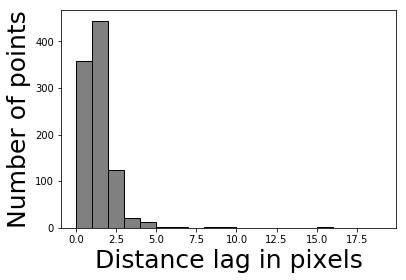

In [15]:
plt.hist(relative_distance_lag, bins=range(0,20,1), histtype='bar', color='gray', ec='black')
plt.xlabel('Distance lag in pixels',fontsize=25)
plt.ylabel('Number of points',fontsize=25)
plt.xticks(fontsize = 10) 
plt.yticks(fontsize = 10)
plt.show()

In [16]:
angle_lag = []
for i in range(len(vecGt)):
    angle_lag.append(angle_between(vecGt[i], vecComputed[i])*(180/math.pi))
nanlist=[]
for ii in range(len(angle_lag)):
    if np.isnan(angle_lag[ii]):
        nanlist.append(ii)
        angle_lag[ii]=0
print(nanlist)
print(np.median(angle_lag))

[215, 282, 540, 656, 725, 726]
79.03619375296738


/Users/prakash/anaconda/envs/Py35forBobSeg/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide


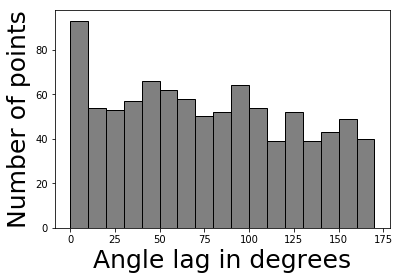

In [17]:
plt.hist(angle_lag, bins=range(0,180,10), histtype='bar', color='gray', ec='black')
plt.xlabel('Angle lag in degrees',fontsize=25)
plt.ylabel('Number of points',fontsize=25)
plt.xticks(fontsize = 10) 
plt.yticks(fontsize = 10)
plt.show()

In [18]:
flows = bsu.compute_flow( denoised_image )
flow_x, flow_y = bsu.split_flow_components( flows )
avg_flow_x = bsu.flow_average(flow_x, 1)
avg_flow_y = bsu.flow_average(flow_y, 1)
total_avg_flow_x = np.average(flow_x, axis=0)
total_avg_flow_y = np.average(flow_y, axis=0)

............................................................. ...done!


In [19]:
imsave(base_path + "OF_x.tif", avg_flow_x)
imsave(base_path + "OF_y.tif", avg_flow_y)

In [20]:
flow_vectors_computed = []
for vec in range(len(flow_vectors_gt)):
    int_x = round(flow_vectors_gt[vec][0])
    int_y = round(flow_vectors_gt[vec][1])
    time = flow_vectors_gt[vec][4]
    computed_u = avg_flow_x[time][int_y][int_x]
    computed_v = avg_flow_y[time][int_y][int_x]
    flow_vectors_computed.append((int_x, int_y, computed_u, computed_v, time))

In [21]:
final_coordinates_gt = []
final_coordinates_computed = []
initial_coordinates = []
for i in range(len(flow_vectors_gt)):
    
    final_coordinates_gt.append((flow_vectors_gt[i][0]+flow_vectors_gt[i][2], flow_vectors_gt[i][1]+flow_vectors_gt[i][3]))
    final_coordinates_computed.append((flow_vectors_computed[i][0]+flow_vectors_computed[i][2], flow_vectors_computed[i][1]+flow_vectors_computed[i][3]))
    initial_coordinates.append((flow_vectors_gt[i][0],flow_vectors_gt[i][1]))

In [22]:
vecGt = subVector(initial_coordinates, final_coordinates_gt)
vecComputed = subVector(initial_coordinates, final_coordinates_computed)

In [23]:
distance_gt = []
for i in range(len(vecGt)):
    distance_gt.append(euclidean(final_coordinates_gt[i], initial_coordinates[i]))

In [24]:
distance_lag = []
relative_distance_lag = []
for i in range(len(vecGt)):
    p1 = vecGt[i]
    p2 = vecComputed[i]

    distance =euclidean(p1,p2)
    distance_lag.append(distance)
    relative_distance_lag.append(distance/(distance_gt[i]+1e-50))

In [25]:
print(np.median(distance_lag), np.median(relative_distance_lag))

2.0816519138863354 0.6679815237482052


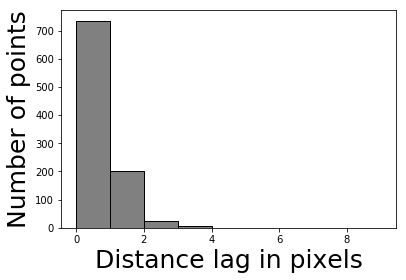

In [26]:
plt.hist(relative_distance_lag, bins=range(0,10,1), histtype='bar', color='gray', ec='black')
plt.xlabel('Distance lag in pixels',fontsize=25)
plt.ylabel('Number of points',fontsize=25)
plt.xticks(fontsize = 10) 
plt.yticks(fontsize = 10)
plt.show()

In [27]:
angle_lag = []
for i in range(len(vecGt)):
    angle_lag.append(angle_between(vecGt[i], vecComputed[i])*(180/math.pi))
nanlist=[]
for ii in range(len(angle_lag)):
    if np.isnan(angle_lag[ii]):
        nanlist.append(ii)
        angle_lag[ii]=0
print(nanlist)
print(np.median(angle_lag))

[215, 282, 540, 656, 725, 726]
29.197391273973448


/Users/prakash/anaconda/envs/Py35forBobSeg/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide


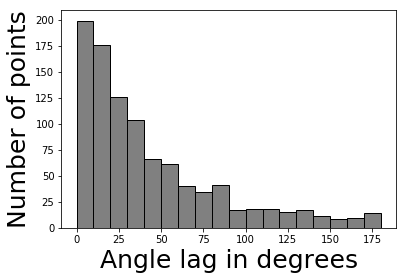

In [28]:
plt.hist(angle_lag, bins=range(0,189,10), histtype='bar', color='gray', ec='black')
plt.xlabel('Angle lag in degrees',fontsize=25)
plt.ylabel('Number of points',fontsize=25)
plt.xticks(fontsize = 10) 
plt.yticks(fontsize = 10)
plt.show()

### Export computed tracklets for visulaization in GUI

In [29]:
iden = 0
visulaizatiuon_puncta = []
for i in range(len(flow_vectors_gt)):
    
    x1 = flow_vectors_gt[i][0]
    y1 = flow_vectors_gt[i][1]
    time1 = int(flow_vectors_gt[i][4])
    x2 = final_coordinates_computed[i][0]
    y2 = final_coordinates_computed[i][1]
    time2 = time1+1
    computed_puncta1 = [iden, x1, y1, time1]
    computed_puncta1 = ','.join(map(str, computed_puncta1)) 
    computed_puncta2 = [iden+1, x2, y2, time2]
    computed_puncta2 = ','.join(map(str, computed_puncta2)) 
    visulaizatiuon_puncta.append(computed_puncta1)
    visulaizatiuon_puncta.append(computed_puncta2)
    iden+=2
visulaizatiuon_puncta.insert(0, "id,x,y,t")

In [30]:
visualization_edges = []
for i in range(0, len(visulaizatiuon_puncta), 2):
    computed_edge = [i, i+1]
    computed_edge = ','.join(map(str, computed_edge)) 
    visualization_edges.append(computed_edge)
visualization_edges.insert(0, "edgep1,edgep2")
full = [visulaizatiuon_puncta, visualization_edges]
a = []
for x in full:
    for y in x:
        a.append(y)

In [31]:
with open(base_path+ '/visualization_tracklets.csv', 'w') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL,delimiter='\n')
    wr.writerow(a)

In [32]:
initial_coordinates

[(292.8114, 617.516),
 (290.8013, 617.0222),
 (284.46326, 613.93567),
 (279.93692, 611.94617),
 (278.10458, 605.8291),
 (274.48108, 603.6351),
 (266.85178, 603.9676),
 (263.54016, 604.38275),
 (277.1515, 622.16925),
 (276.11823, 618.77563),
 (271.68857, 615.7357),
 (271.3251, 609.9609),
 (269.61227, 606.57007),
 (247.72702, 672.10236),
 (243.9797, 669.73926),
 (246.491, 668.98145),
 (247.38167, 670.7446),
 (252.60564, 668.6166),
 (252.92033, 662.49915),
 (251.02565, 664.47766),
 (248.3592, 660.5471),
 (247.71054, 651.5115),
 (246.15843, 654.16815),
 (243.85406, 655.67267),
 (242.16214, 657.37854),
 (240.53455, 658.2007),
 (234.41573, 657.5462),
 (231.40254, 651.91815),
 (235.68265, 651.6288),
 (232.69872, 653.13605),
 (234.06062, 653.81006),
 (232.55333, 650.8261),
 (233.23846, 652.18243),
 (229.15414, 650.50024),
 (232.00801, 650.4206),
 (229.68832, 648.18756),
 (228.58932, 645.3378),
 (152.54701, 548.87604),
 (153.4335, 549.61993),
 (156.23001, 552.12286),
 (152.82246, 549.75836),
 (

In [33]:
final_coordinates_computed

[(292.167784512043, 617.9884990304708),
 (288.43666195869446, 615.8949565887451),
 (280.96182513237, 612.177612900734),
 (277.45279598236084, 608.7419354915619),
 (274.3165247440338, 603.0928840637207),
 (271.6207549571991, 603.8733851164579),
 (264.57180643081665, 603.0439226031303),
 (261.51899456977844, 604.0635209083557),
 (275.8696001768112, 623.417297244072),
 (273.156124830246, 619.1692587584257),
 (269.57618618011475, 613.3062534332275),
 (269.4751695394516, 607.2701532840729),
 (269.9071212634444, 606.0828180909157),
 (246.11487066745758, 671.4918446540833),
 (242.61407911777496, 668.8982478380203),
 (245.96725038811564, 668.8850587978959),
 (249.7090084552765, 670.4624152183533),
 (256.62022709846497, 670.7765446901321),
 (252.2001497745514, 664.109138250351),
 (248.5774281024933, 664.961728155613),
 (246.99360930919647, 661.5440022349358),
 (245.46457505226135, 654.5026075839996),
 (243.92442345619202, 657.3410835266113),
 (243.31767016649246, 657.8632111549377),
 (240.12348

In [34]:
final_coordinates_gt

[(290.8013, 617.0222),
 (284.46326, 613.93567),
 (279.93692, 611.94617),
 (278.10458, 605.8291),
 (274.48108, 603.6351),
 (266.85178, 603.9676),
 (263.54016, 604.38275),
 (259.6109, 601.0856),
 (276.11823, 618.77563),
 (271.68857, 615.7357),
 (271.3251, 609.9609),
 (269.61227, 606.57007),
 (266.85178, 603.9676),
 (243.9797, 669.73926),
 (246.491, 668.98145),
 (247.38167, 670.7446),
 (252.60564, 668.6166),
 (252.92033, 662.49915),
 (251.02565, 664.47766),
 (248.3592, 660.5471),
 (247.71054, 651.5115),
 (246.15843, 654.16815),
 (243.85406, 655.67267),
 (242.16214, 657.37854),
 (240.53455, 658.2007),
 (234.41573, 657.5462),
 (231.40254, 651.91815),
 (235.68265, 651.6288),
 (232.69872, 653.13605),
 (234.06062, 653.81006),
 (232.55333, 650.8261),
 (233.23846, 652.18243),
 (229.15414, 650.50024),
 (232.00801, 650.4206),
 (229.68832, 648.18756),
 (228.58932, 645.3378),
 (228.0454, 645.2721),
 (153.4335, 549.61993),
 (156.23001, 552.12286),
 (152.82246, 549.75836),
 (154.24312, 548.1895),
 (15